# Learnable loss

## Setup

In [1]:
import numpy as np

%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch

import higher

from ltl.determinism_helper import seed_generators
seed_generators(2)

from ltl.label_smoothing_loss import LabelSmoothingLoss
from ltl import utils

## Data

In [2]:
data_x = 0.0
data_y = -2.0
data_size = 0.3
data_width = 12.0
data_height = 6.0
data_counts = ([200,200,200],[75,75,75],[75,75,75])
data_counts_acc = ([0],[0],[0])
for i in range(len(data_counts)):
    for j in range(len(data_counts[i])):
        data_counts_acc[i].append(data_counts_acc[i][j]+data_counts[i][j])
data_functions = [
    lambda x: torch.cos(x), 
    lambda x: torch.full_like(x, 3.0)
]

def generateData(counts):
    #Generate random points
    points = torch.rand((counts[0], 2), dtype=torch.float32)
    points[:,0] = data_x+points[:,0]*data_width
    points[:,1] = data_y+points[:,1]*data_height
    labels = torch.zeros((counts[0],), dtype=torch.long)

    #Remove random points from areas around functions
    for func in data_functions:
        points[:,1] += data_size*(torch.abs(points[:,1]-func(points[:,0]))<data_size)*torch.sign(points[:,1]-func(points[:,0]))

    #Generate points at function
    for i in range(len(data_functions)):
        tmp = data_x+torch.rand((counts[i+1],), dtype=torch.float32)*data_width
        points = torch.cat((points, torch.stack((tmp, data_functions[i](tmp)+(2.0*torch.rand((counts[i+1],))-1.0)*2.0/3.0*data_size), dim=1)))
        labels = torch.cat((labels, torch.full((counts[i+1],), i+1, dtype=torch.long)))

    return points, labels

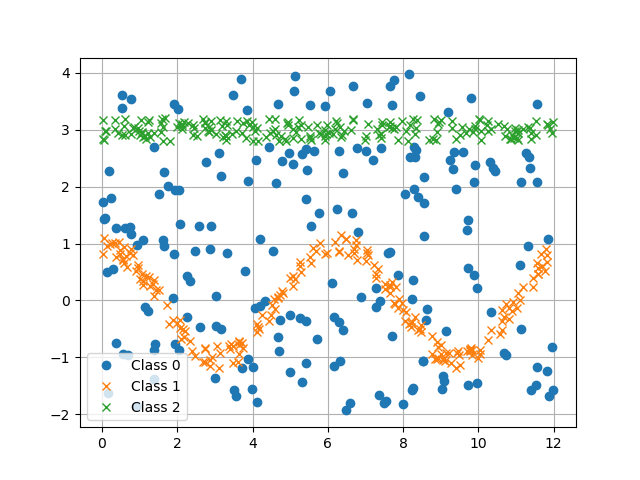

In [3]:
x_train, y_train = generateData(data_counts[0])

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_train[:data_counts_acc[0][1],0], x_train[:data_counts_acc[0][1],1], 'o', label='Class 0')
axes.plot(x_train[data_counts_acc[0][1]:data_counts_acc[0][2],0], x_train[data_counts_acc[0][1]:data_counts_acc[0][2],1], 'x', label='Class 1')
axes.plot(x_train[data_counts_acc[0][2]:,0], x_train[data_counts_acc[0][2]:,1], 'x', label='Class 2')
axes.legend()
axes.grid()

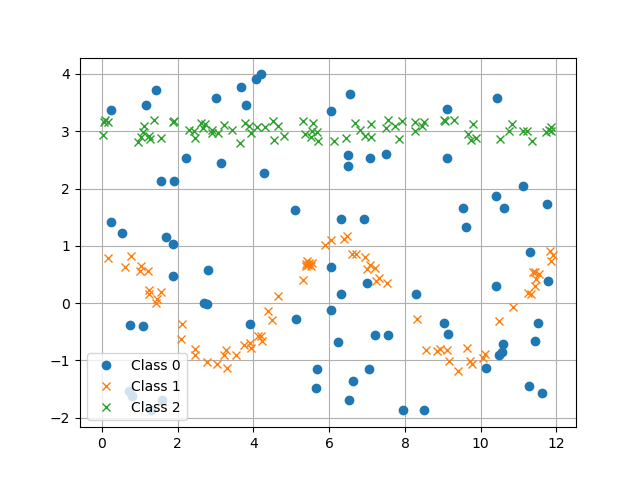

In [4]:
x_val, y_val = generateData(data_counts[1])

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_val[:data_counts_acc[1][1],0], x_val[:data_counts_acc[1][1],1], 'o', label='Class 0')
axes.plot(x_val[data_counts_acc[1][1]:data_counts_acc[1][2],0], x_val[data_counts_acc[1][1]:data_counts_acc[1][2],1], 'x', label='Class 1')
axes.plot(x_val[data_counts_acc[1][2]:,0], x_val[data_counts_acc[1][2]:,1], 'x', label='Class 2')
axes.legend()
axes.grid()

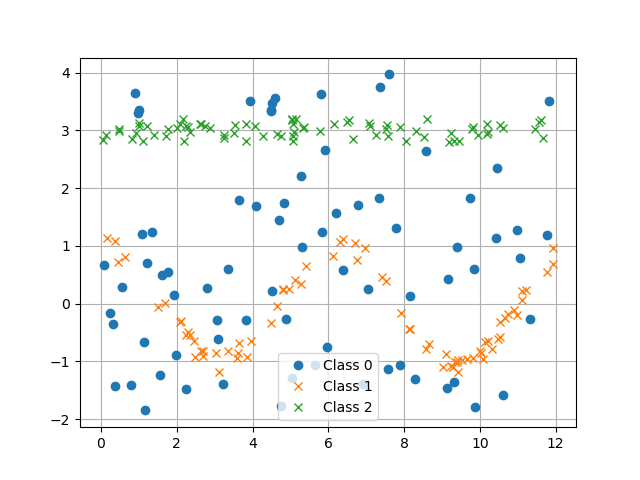

In [5]:
x_test, y_test = generateData(data_counts[2])

fig = plt.figure()
axes = fig.add_subplot(111)
axes.plot(x_test[:data_counts_acc[2][1],0], x_test[:data_counts_acc[2][1],1], 'o', label='Class 0')
axes.plot(x_test[data_counts_acc[2][1]:data_counts_acc[2][2],0], x_test[data_counts_acc[2][1]:data_counts_acc[2][2],1], 'x', label='Class 1')
axes.plot(x_test[data_counts_acc[2][2]:,0], x_test[data_counts_acc[2][2]:,1], 'x', label='Class 2')
axes.legend()
axes.grid()

## Model

In [6]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        count_hidden = 100
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(2, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, count_hidden),
            torch.nn.ReLU(),
            torch.nn.Linear(count_hidden, 3)
        )

    def forward(self, x):
        return self.layers(x)

## Standard

### Training

In [7]:
model = Net()
model.cuda()
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

#############
optimizer.zero_grad()
loss_function(model(x_train[0].unsqueeze(0)), y_train[0].unsqueeze(0)).backward()
optimizer.step()
#############

epochs = 1000
losses = np.zeros((epochs,))
accuracy = np.zeros((epochs,))

for i in range(epochs):
    z_train = model(x_train)
    loss = loss_function(z_train, y_train)
    print(f"Loss: {loss.item()}")
    losses[i] = loss.item()
    accuracy[i] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {loss_function(z_test, y_test)}")

Loss: 1.331146240234375

Loss: 1.3213263750076294

Loss: 1.2784852981567383

Loss: 1.2210015058517456

Loss: 1.158690333366394

Loss: 1.1018766164779663

Loss: 1.0536317825317383

Loss: 1.0160529613494873

Loss: 0.988149106502533

Loss: 0.9684507250785828

Loss: 0.9535003900527954

Loss: 0.941148579120636

Loss: 0.9293964505195618

Loss: 0.9173187017440796

Loss: 0.9052457809448242

Loss: 0.8927068114280701

Loss: 0.8798462748527527

Loss: 0.866935133934021

Loss: 0.854205310344696

Loss: 0.8419432640075684

Loss: 0.8301778435707092

Loss: 0.8186674118041992

Loss: 0.8085981011390686

Loss: 0.8004688024520874

Loss: 0.7938086986541748

Loss: 0.7873420715332031

Loss: 0.7806792259216309

Loss: 0.7739681005477905

Loss: 0.7676705718040466

Loss: 0.7616353631019592

Loss: 0.7556911110877991

Loss: 0.750006914138794

Loss: 0.744400680065155

Loss: 0.7391940355300903

Loss: 0.7343963980674744

Loss: 0.7299646735191345

Loss: 0.7255474925041199

Loss: 0.7209137678146362

Loss: 0.716157376766

### Evaluation

No handles with labels found to put in legend.
No handles with labels found to put in legend.


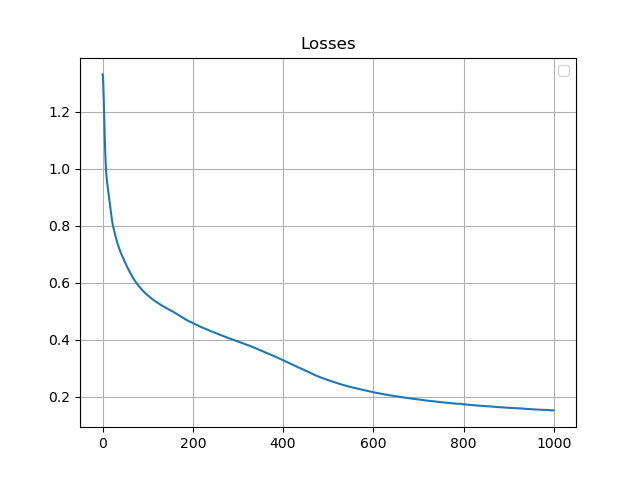

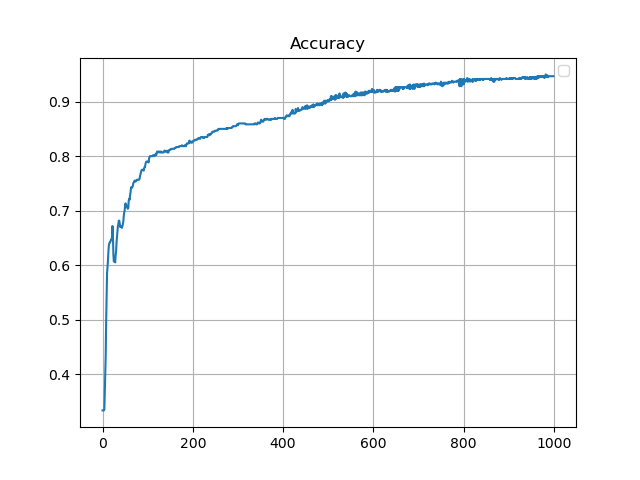

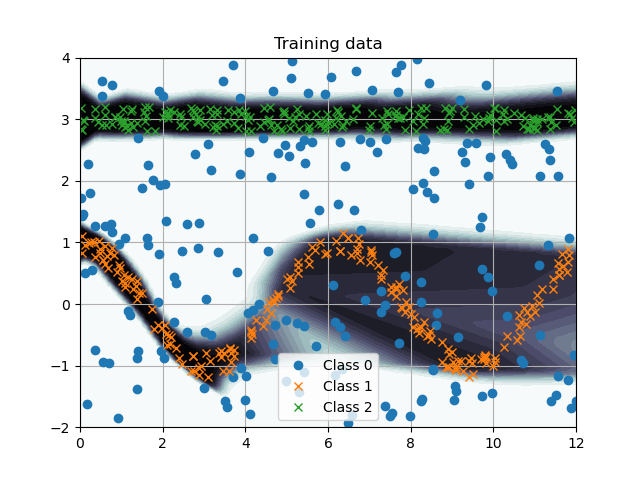

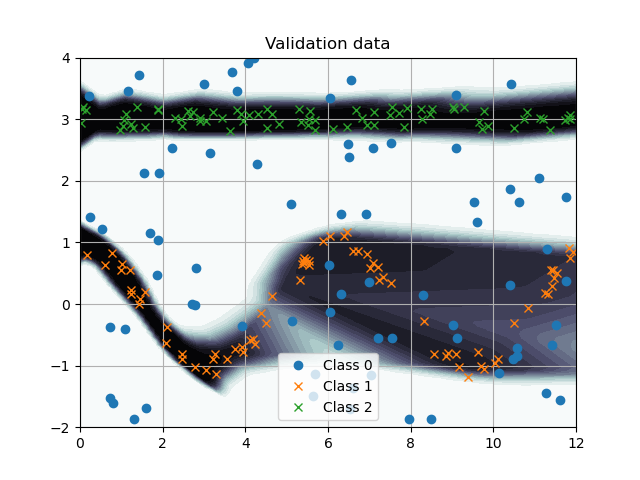

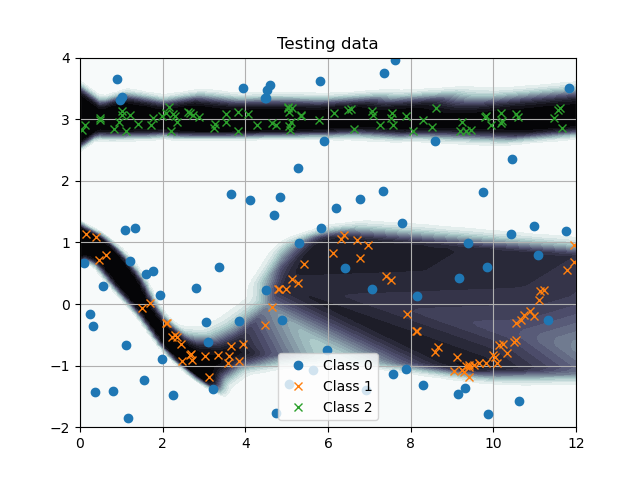

In [8]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Losses")
axes.plot(np.arange(losses.shape[0]), losses)
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(accuracy.shape[0]), accuracy)
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution))
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[:data_counts_acc[0][1],0].cpu(), x_train[:data_counts_acc[0][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[data_counts_acc[0][1]:data_counts_acc[0][2],0].cpu(), x_train[data_counts_acc[0][1]:data_counts_acc[0][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[data_counts_acc[0][2]:,0].cpu(), x_train[data_counts_acc[0][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[:data_counts_acc[1][1],0].cpu(), x_val[:data_counts_acc[1][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[data_counts_acc[1][1]:data_counts_acc[1][2],0].cpu(), x_val[data_counts_acc[1][1]:data_counts_acc[1][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[data_counts_acc[1][2]:,0].cpu(), x_val[data_counts_acc[1][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[:data_counts_acc[2][1],0].cpu(), x_test[:data_counts_acc[2][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[data_counts_acc[2][1]:data_counts_acc[2][2],0].cpu(), x_test[data_counts_acc[2][1]:data_counts_acc[2][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[data_counts_acc[2][2]:,0].cpu(), x_test[data_counts_acc[2][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

## Bilevel

### Training

In [9]:
model = Net()
model.cuda()
inner_loss_function = LabelSmoothingLoss(3, torch.diag(torch.ones((3,))))
inner_loss_function.cuda()
outer_loss_function = torch.nn.CrossEntropyLoss()
inner_optimizer = torch.optim.Adam(model.parameters())
outer_optimizer = torch.optim.SGD(inner_loss_function.parameters(), lr=1e-1)

x_train = x_train.cuda()
y_train = y_train.cuda()
x_val   = x_val.cuda()
y_val   = y_val.cuda()
x_test  = x_test.cuda()
y_test  = y_test.cuda()

#############
inner_optimizer.zero_grad()
inner_loss_function(model(x_train[0].unsqueeze(0)), y_train[0].unsqueeze(0)).backward()
inner_optimizer.step()
#############

epochs = 1000
inner_iterations = 5
inner_losses   = np.zeros((epochs*inner_iterations,))
outer_losses   = np.zeros((epochs,))
inner_accuracy = np.zeros((epochs*inner_iterations,))
outer_accuracy = np.zeros((epochs,))

for i in range(epochs):
    with higher.innerloop_ctx(model, inner_optimizer) as (fmodel, diffopt):
        for j in range(inner_iterations):
            z_train = fmodel(x_train)
            inner_loss = inner_loss_function(z_train, y_train)
            print(f"Inner loss {j}: {inner_loss.item()}")
            inner_losses[i*inner_iterations+j] = inner_loss.item()
            inner_accuracy[i*inner_iterations+j] = (torch.argmax(torch.nn.functional.softmax(z_train, dim=1), dim=1)==y_train).sum()/data_counts_acc[0][len(data_counts_acc[0])-1]
            diffopt.step(inner_loss)
        new_model_state = fmodel.state_dict()
        new_optimizer_state = diffopt.state[0]
            
        z_val = fmodel(x_val)
        outer_loss = outer_loss_function(z_val, y_val)
        outer_accuracy[i] = (torch.argmax(torch.nn.functional.softmax(z_val, dim=1), dim=1)==y_val).sum()/data_counts_acc[1][len(data_counts_acc[1])-1]
        print(f"Outer loss: {outer_loss.item()}")
        outer_losses[i] = outer_loss.item()
        outer_optimizer.zero_grad()
        outer_loss.backward()
        outer_optimizer.step()

    utils.copy_higher_to_torch(new_model_state, new_optimizer_state, model, inner_optimizer)
                    
    print()

model.eval()
with torch.no_grad():
    z_test = model(x_test)
    print(f"Test loss: {inner_loss_function(z_test, y_test)}")

Inner loss 0: 1.2234528064727783
Inner loss 1: 1.1829323768615723
Inner loss 2: 1.1373107433319092
Inner loss 3: 1.1066677570343018
Inner loss 4: 1.0930980443954468
Outer loss: 1.034589171409607

Inner loss 0: 1.0891742706298828
Inner loss 1: 1.0868157148361206
Inner loss 2: 1.0834628343582153
Inner loss 3: 1.0804795026779175
Inner loss 4: 1.0789870023727417
Outer loss: 0.9746206998825073

Inner loss 0: 1.0778306722640991
Inner loss 1: 1.0754109621047974
Inner loss 2: 1.0709228515625
Inner loss 3: 1.0656503438949585
Inner loss 4: 1.0613709688186646
Outer loss: 0.9096300601959229

Inner loss 0: 1.0591766834259033
Inner loss 1: 1.059896469116211
Inner loss 2: 1.0620847940444946
Inner loss 3: 1.063938856124878
Inner loss 4: 1.064372181892395
Outer loss: 0.9012919664382935

Inner loss 0: 1.0631730556488037
Inner loss 1: 1.0616455078125
Inner loss 2: 1.0600459575653076
Inner loss 3: 1.0586793422698975
Inner loss 4: 1.0576181411743164
Outer loss: 0.9028070569038391

Inner loss 0: 1.056435346

### Evaluation

In [ ]:
model.eval()
model.cuda()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Loss")
axes.plot(np.arange(inner_losses.shape[0]), inner_losses, label='Inner')
axes.plot(np.arange(outer_losses.shape[0])*5, outer_losses, label='Outer')
axes.legend()
axes.grid()

fig = plt.figure()
axes = fig.add_subplot(111)
axes.set_title("Accuracy")
axes.plot(np.arange(inner_accuracy.shape[0]), inner_accuracy, label='Inner')
axes.plot(np.arange(outer_accuracy.shape[0])*5, outer_accuracy, label='Outer')
axes.legend()
axes.grid()

with torch.no_grad():
    resolution = 100
    grid_x, grid_y = torch.meshgrid(torch.linspace(data_x, data_x+data_width, resolution), torch.linspace(data_y, data_y+data_height, resolution))
    grid = torch.cat((torch.reshape(grid_x, (-1,1)), torch.reshape(grid_y, (-1,1))), 1)
    
    probs = torch.nn.functional.softmax(model(grid.cuda()), dim=1).cpu()
    output = torch.reshape(probs[:,0], (resolution,resolution))

    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Training data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_train[:data_counts_acc[0][1],0].cpu(), x_train[:data_counts_acc[0][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_train[data_counts_acc[0][1]:data_counts_acc[0][2],0].cpu(), x_train[data_counts_acc[0][1]:data_counts_acc[0][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_train[data_counts_acc[0][2]:,0].cpu(), x_train[data_counts_acc[0][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Validation data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_val[:data_counts_acc[1][1],0].cpu(), x_val[:data_counts_acc[1][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_val[data_counts_acc[1][1]:data_counts_acc[1][2],0].cpu(), x_val[data_counts_acc[1][1]:data_counts_acc[1][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_val[data_counts_acc[1][2]:,0].cpu(), x_val[data_counts_acc[1][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()
    
    fig = plt.figure()
    axes = fig.add_subplot(111)
    axes.set_title("Testing data")
    axes.contourf(grid_x.detach().numpy(), grid_y.detach().numpy(), output.detach().numpy(), np.linspace(0, 1, 20), cmap=plt.cm.bone)
    axes.plot(x_test[:data_counts_acc[2][1],0].cpu(), x_test[:data_counts_acc[2][1],1].cpu(), 'o', label='Class 0')
    axes.plot(x_test[data_counts_acc[2][1]:data_counts_acc[2][2],0].cpu(), x_test[data_counts_acc[2][1]:data_counts_acc[2][2],1].cpu(), 'x', label='Class 1')
    axes.plot(x_test[data_counts_acc[2][2]:,0].cpu(), x_test[data_counts_acc[2][2]:,1].cpu(), 'x', label='Class 2')
    axes.legend()
    axes.grid()

    utils.render_matrix(inner_loss_function.smoothing.clone().detach().cpu().numpy(), "Smoothing matrix", "Weight", "Correct label")